# Minplus algebra experiment

This code attempts to learn the 2D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

This is ostensibly the same code as the file in the _hjpdes_experiments_1D folder, except that we use here
the LPN module directly. This is because the experiments in _hjpdes_experiments_1D rely on the utils.py and network.py
files which assume the input is one-dimensional.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert


# set location
MODEL_DIR = "experiments/models/minplus_2D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": True})
sns.set_theme()

Notes: The Euclidean norm function requires something for the tensor gradient... fix this later...

## Parameters, utility functions, and plotting tool

In [16]:
#--- Parameters ---#
# dimension
dim = 2

# prior parameters
mu1 = np.array([1.0, 0.0])
mu2 = np.array([1.0, 1.0]/np.sqrt(2.0))
sigma1 = 1.0
sigma2 = 1.0

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 100     # number of hidden units
layers = 6      # number of layers

# optimization algorithm to use for computing the prior
# cvx_cg, cvx_gd
INVERT_MODE = "cvx_gd"



#--- Utility functions ---#
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)

def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

# Proximal matching loss (-exp(-(x/gamma)^2) + 1) for training the LPN
def exp_func(x, gamma):
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0

# Target convex function to train
def cvx_true(y,mu1,mu2,sigma1,sigma2):
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    val = 0.5*pow(euclid_norm(y),2) - np.minimum(val1,val2)
    return val

# Target prior function to learn
def prior_true(y,mu1,mu2,sigma1,sigma2):
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    val = np.minimum(val1,val2)
    return val

#--- Plotting tool ---#
# 1) This function plots the estimated convex and prior functions
def plot_all(model,a,b,data_points,mu1,mu2,sigma1,sigma2):
    """ Plot the estimated/true convex functions and the estimated/true priors
        over the square [a,b]^2  with 3*data_points in each dimension.

        For all functions, we plot the cross sections
        (x1,0) and (0,x2) to visualize how they differ.
    """
    # Create a meshgrid over [a,b]^2 with data_points*3 points,
    # and compute the points along the cross-sections (x1,0) and (0,x2).
    xi = np.linspace(a, b, data_points*3)
    x1_0_points = np.array(np.meshgrid(xi, 0)).reshape(2, -1).T
    x2_0_points = np.array(np.meshgrid(0, xi)).reshape(2, -1).T

    # Compute the true and estimates convex functions at these cross-sections
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)

    # Compute the true and estimated convex and prior functions at these cross-sections
    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    y = invert(x1_0_points,model,INVERT_MODE)
    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    x1_0_prior_est =  np.sum(x1_0_points*y, axis = 1) - 0.5 * euclid_norm(x1_0_points) - psi

    y = invert(x2_0_points,model,INVERT_MODE)
    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    x2_0_prior_est =  np.sum(x2_0_points*y, axis = 1) - 0.5 * euclid_norm(x2_0_points) - psi


    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()


    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()

 
    # # 3D plot of the convex function
    # plt.subplot(1, 2, 1)
    # plt.plot(xi, c, "-", ms=5, label="Cvx func")
    # plt.plot(xi, cvx_true(xi,mu1,mu2,sigma1,sigma2), "--", label="ref.", zorder=1.9)
    # plt.grid("on")
    # plt.legend()
    # plt.title("Cvx func")

    # # 3D plot of the original function
    # plt.subplot(1, 2, 2)
    # plt.plot(xi, p, label="LPN")
    # plt.plot(xi, prior_true(xi,mu1,mu2,sigma1,sigma2), "--", label="ref", zorder=1.9)
    # plt.grid("on")
    # plt.legend()
    # plt.title("Original func")

    # plt.tight_layout()




# Old
# True proximal operator we want to reconstruct
# def prox_true(y,mu1,mu2,sigma1,sigma2):
#     val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
#     val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
#     val = (mu1 + sigma1*y)*(val1 <= val2)/(1 + sigma1) + (mu2 + sigma2*y)*(val1 > val2)/(1+sigma2)
#     return val

#y = prox(xi, model)
# # learned prox
# plt.subplot(1, 3, 1)
# plt.plot(xi, y, "-", ms=5, label="LPN")
# plt.plot(xi, prox_true(xi,mu1,mu2,sigma1,sigma2), "--", label="ref.", zorder=1.9)
# plt.grid("on")
# plt.legend()
# plt.title("Learned prox")


# Example: Visualize the target convex and prior functions

Text(0, 0.5, 'prior_true($x_2$,0)')

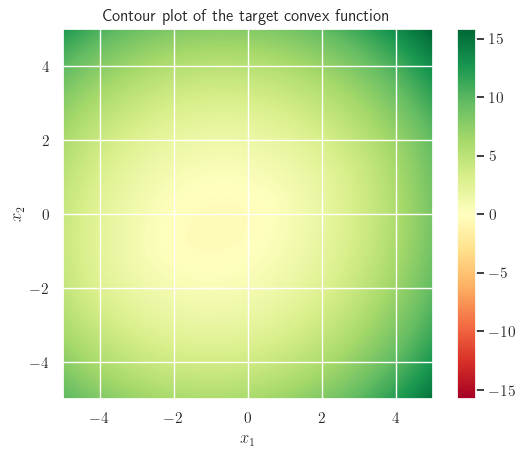

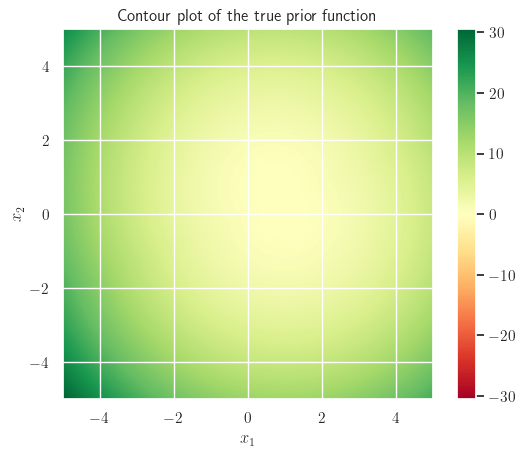

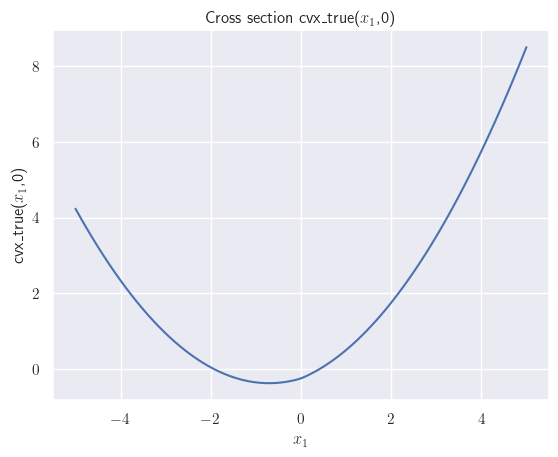

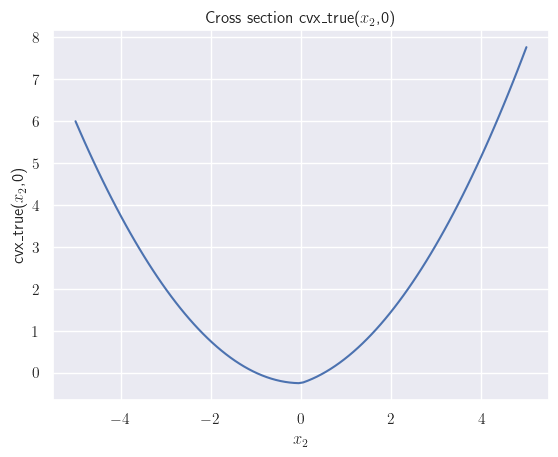

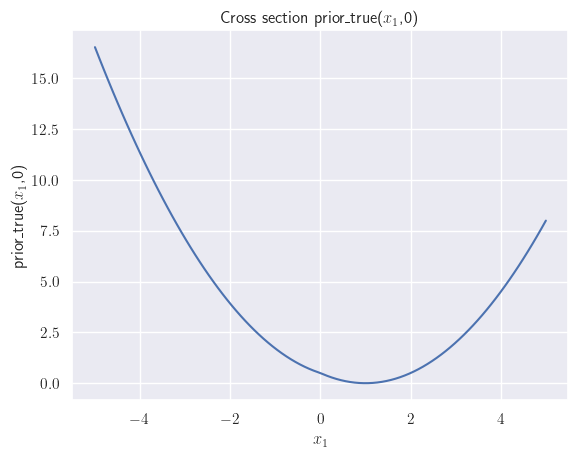

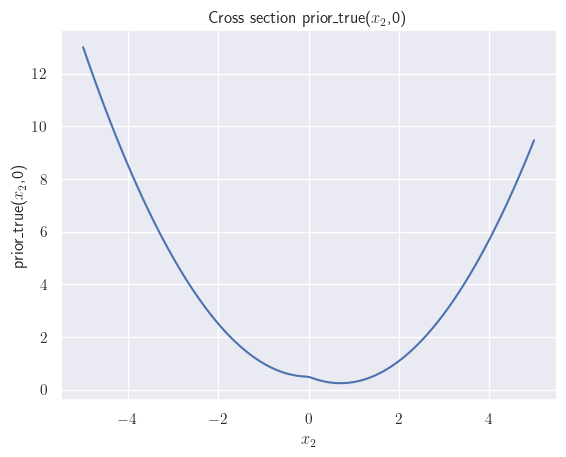

In [3]:
# Generate an [-a, a]^2 square meshgrid
a, spacing = 5, 100
xi = np.linspace(-a, a, spacing)
mesh = np.meshgrid(xi, xi) 

# Recover the list of points as a matrix with 2 columns
pts = np.array(mesh).reshape(2, -1).T

# Evaluate the target convex and prior functions, then reshape them to fit the meshgrid
example_cvx_true = cvx_true(pts,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)
example_prior_true = prior_true(pts,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)

# Plot 2D contours cvx_true(x1,x2) = C
fig1, ax1 = plt.subplots()
im1 = ax1.imshow(example_cvx_true, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-a, a, -a, a],
               vmax=abs(example_cvx_true).max(), vmin=-abs(example_cvx_true).max())

plt.title('Contour plot of the target convex function')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(im1)

# Plot 2D contours prior_true(x1,x2) = C
fig2, ax2 = plt.subplots()
im2 = ax2.imshow(example_prior_true, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-a, a, -a, a],
               vmax=abs(example_prior_true).max(), vmin=-abs(example_prior_true).max())

plt.title('Contour plot of the true prior function')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(im2)

# Plot the cross sections cvx_true(x1,0), cvx_true(0,x2), prior_true(x1,0) and prior_true(0,x2)
x1_0_points = np.array(np.meshgrid(xi, 0) ).reshape(2, -1).T
x2_0_points = np.array(np.meshgrid(0, xi) ).reshape(2, -1).T

x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)
x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)

x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)
x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)

plt.subplots()
plt.plot(xi, x1_0_cvx_true, "-", ms=5)
plt.grid("on")
plt.title("Cross section cvx_true($x_1$,0)")
plt.xlabel('$x_1$')
plt.ylabel('cvx_true($x_1$,0)')

plt.subplots()
plt.plot(xi, x2_0_cvx_true, "-", ms=5)
plt.grid("on")
plt.title("Cross section cvx_true($x_2$,0)")
plt.xlabel('$x_2$')
plt.ylabel('cvx_true($x_2$,0)')

plt.subplots()
plt.plot(xi, x1_0_prior_true, "-", ms=5)
plt.grid("on")
plt.title("Cross section prior_true($x_1$,0)")
plt.xlabel('$x_1$')
plt.ylabel('prior_true($x_1$,0)')

plt.subplots()
plt.plot(xi, x2_0_prior_true, "-", ms=5)
plt.grid("on")
plt.title("Cross section prior_true($x_2$,0)")
plt.xlabel('$x_2$')
plt.ylabel('prior_true($x_2$,0)')

## Generate training data

In [4]:
# generate samples {yi} uniformly in the square [a,b]
data_points = 200
a = -4
b = 4

input = np.zeros((2,data_points))
input[0] = np.random.uniform(a,b,data_points)
input[1] = np.random.uniform(a,b,data_points)
input = input.reshape(data_points,2)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast and samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss=None):
    # Compute the convex function from the input
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(40000):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 14.092735290527344
iteration 0 loss 152566.3125
iteration 500 loss 2000.0562744140625
iteration 1000 loss 550.6840209960938
iteration 1500 loss 231.87254333496094
iteration 2000 loss 115.3661880493164
iteration 2500 loss 62.266666412353516
iteration 3000 loss 34.98984909057617
iteration 3500 loss 20.054414749145508
iteration 4000 loss 11.52108383178711
iteration 4500 loss 6.524561882019043
iteration 5000 loss 3.612943172454834
iteration 5500 loss 1.9370315074920654
iteration 6000 loss 1.0106557607650757
iteration 6500 loss 0.5313665270805359
iteration 7000 loss 0.3061913549900055
iteration 7500 loss 0.2131935954093933
iteration 8000 loss 0.18009592592716217
iteration 8500 loss 0.16862744092941284
iteration 9000 loss 0.16220912337303162
iteration 9500 loss 0.15557587146759033
iteration 10000 loss 0.14763829112052917
iteration 10500 loss 0.13823583722114563
iteration 11000 loss 0.12739859521389008
iteration 11500 loss 0.11528056114912033
iteration 12000 loss 0.1023177430

L2 loss -- Plot

loss -129.06236267089844
loss -679.3975219726562
loss -1118.3304443359375
loss -1516.8521728515625
loss -1872.3341064453125
loss -2170.2353515625
loss -2400.609130859375
loss -2590.12744140625
loss -2752.18896484375
loss -2889.697998046875
loss -3006.323974609375
loss -3106.143798828125
loss -3195.057861328125
loss -3278.0029296875
loss -3358.615966796875
loss -3438.91748046875
loss -3519.64013671875
loss -3600.7900390625
loss -3682.140869140625
loss -3763.5068359375
loss -3844.82568359375
loss -3926.1123046875
loss -4007.39111328125
loss -4088.650390625
loss -4169.83837890625
loss -4250.90087890625
loss -4331.82861328125
loss -4412.646484375
loss -4493.3896484375
loss -4574.07958984375
loss -4654.73193359375
loss -4735.34814453125
loss -4815.92724609375
loss -4896.47900390625
loss -4977.0029296875
loss -5057.509765625
loss -5137.98583984375
loss -5218.43212890625
loss -5298.84814453125
loss -5379.2353515625
final mse:  0.14990760385990143
max, min: 18.63865 -19.193598
loss -129.062362

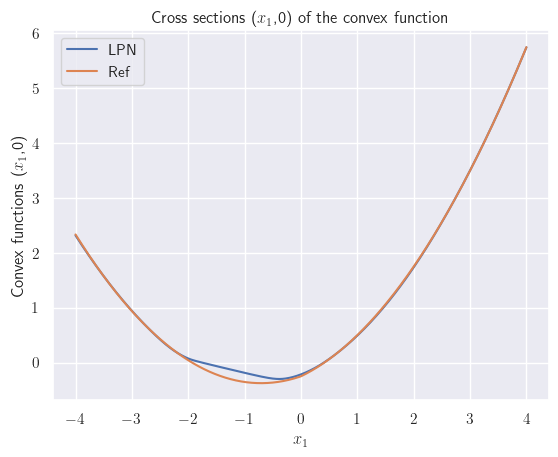

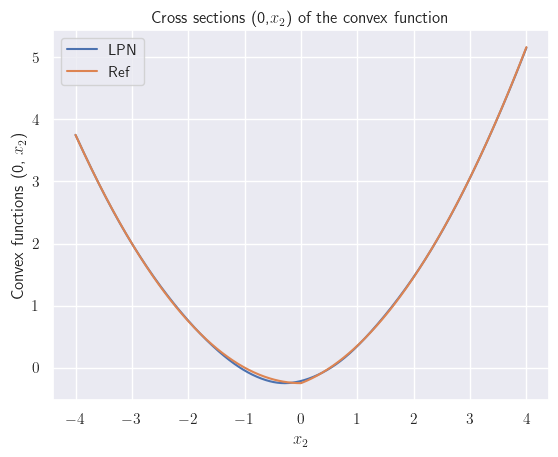

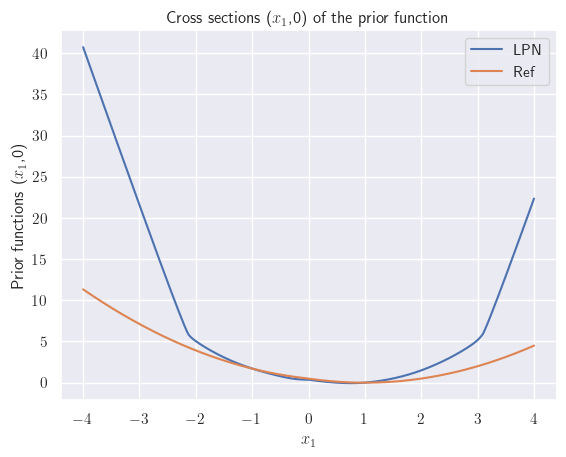

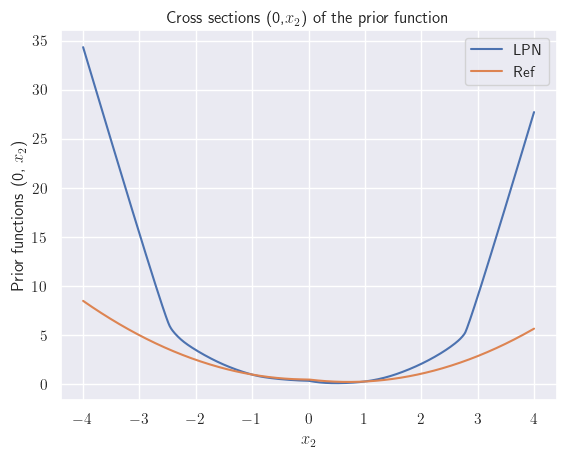

In [17]:
plot_all(lpn_model,a,b,data_points,mu1,mu2,sigma1,sigma2)

L1 loss -- Train

In [8]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

loss_type = 1

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(20000):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

iteration 0 loss 2.822303533554077
iteration 0 loss 417.368896484375
iteration 500 loss 11.179758071899414
iteration 1000 loss 1.8223671913146973
iteration 1500 loss 0.4473256766796112
iteration 2000 loss 0.3632497489452362
iteration 2500 loss 0.29638051986694336
iteration 3000 loss 0.21897880733013153
iteration 3500 loss 0.15600235760211945
iteration 4000 loss 0.10932333022356033
iteration 4500 loss 0.07269705086946487
iteration 5000 loss 0.045670200139284134
iteration 5500 loss 0.023661326617002487
iteration 6000 loss 0.015543032437562943
iteration 6500 loss 0.014161752536892891
iteration 7000 loss 0.011958032846450806
iteration 7500 loss 0.015653375536203384
iteration 8000 loss 0.018495911732316017
iteration 8500 loss 0.01322699710726738
iteration 9000 loss 0.012283355928957462
iteration 9500 loss 0.01230178028345108
iteration 10000 loss 0.013158641755580902
iteration 10500 loss 0.011738005094230175
iteration 11000 loss 0.012613510712981224
iteration 11500 loss 0.01292560063302517
i

L1 loss -- Plot

loss -113.22364044189453
loss -681.3109130859375
loss -1153.7049560546875
loss -1546.276611328125
loss -1875.2598876953125
loss -2151.418701171875
loss -2382.701904296875
loss -2578.036376953125
loss -2743.53857421875
loss -2882.947265625
loss -3000.651123046875
loss -3105.744384765625
loss -3204.014892578125
loss -3298.54345703125
loss -3390.94287109375
loss -3481.992919921875
loss -3572.31689453125
loss -3662.40771484375
loss -3752.518798828125
loss -3842.640625
loss -3932.669921875
loss -4022.530029296875
loss -4112.1875
loss -4201.625
loss -4290.8251953125
loss -4379.7744140625
loss -4468.462890625
loss -4556.896484375
loss -4645.0859375
loss -4733.0556640625
loss -4820.8330078125
loss -4908.44189453125
loss -4995.9140625
loss -5083.265625
loss -5170.51171875
loss -5257.66357421875
loss -5344.7314453125
loss -5431.73876953125
loss -5518.6865234375
loss -5605.5712890625
final mse:  0.161598339676857
max, min: 18.813332 -19.174248
loss -113.22364044189453
loss -719.2534790039062
loss

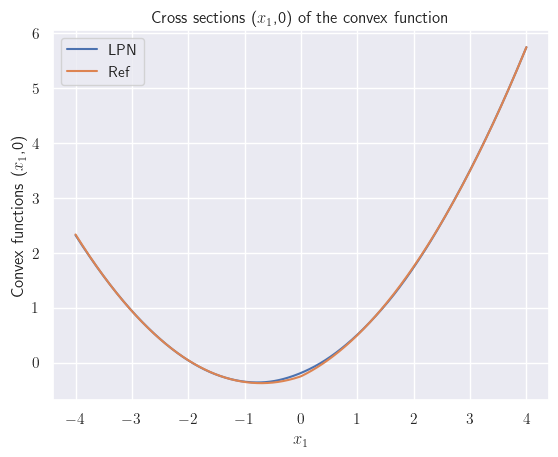

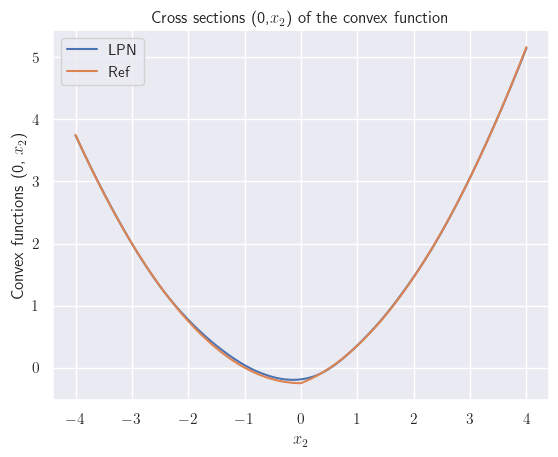

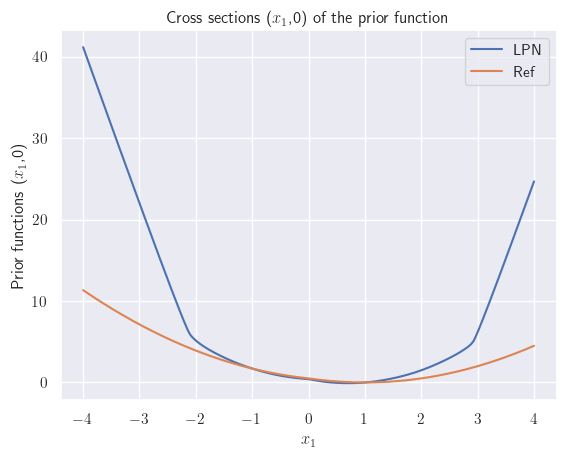

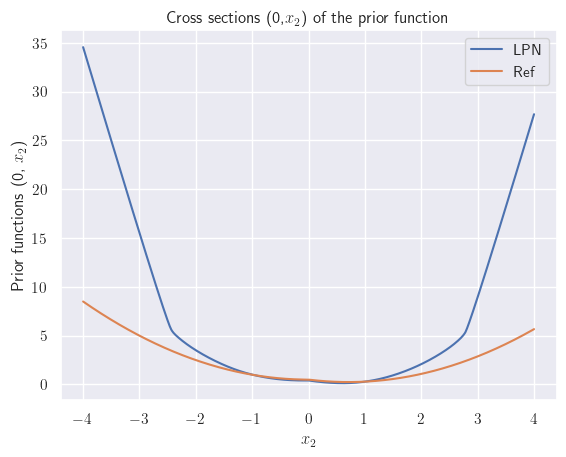

In [9]:
plot_all(lpn_model,a,b,data_points,mu1,mu2,sigma1,sigma2)

Proximal matching loss.
We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma = 20 -- Train

In [10]:
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

loss_type = 0
gamma_loss = 20

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(3000):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(3000):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

iteration 0 loss 0.0374341681599617
iteration 500 loss 0.003389972262084484
iteration 1000 loss 0.0016696363454684615
iteration 1500 loss 0.0013861203333362937
iteration 2000 loss 0.0011373307788744569
iteration 2500 loss 0.0008772295550443232
iteration 0 loss 0.0006340652471408248
iteration 500 loss 0.000608072557952255
iteration 1000 loss 0.0005770158604718745
iteration 1500 loss 0.000539831817150116
iteration 2000 loss 0.0004969924921169877
iteration 2500 loss 0.0004496461187954992


gamma = 20 -- Plot

loss 30.322965621948242
loss -522.1520385742188
loss -937.5913696289062
loss -1283.6680908203125
loss -1597.671142578125
loss -1893.185791015625
loss -2177.657958984375
loss -2451.802001953125
loss -2716.84033203125
loss -2976.121337890625
loss -3232.78466796875
loss -3488.526123046875
loss -3744.447509765625
loss -4001.166015625
loss -4258.73779296875
loss -4516.93798828125
loss -4775.4755859375
loss -5034.11767578125
loss -5292.7431640625
loss -5551.310546875
loss -5809.8017578125
loss -6068.2001953125
loss -6326.47265625
loss -6584.58251953125
loss -6842.4853515625
loss -7100.15869140625
loss -7357.60888671875
loss -7614.8603515625
loss -7871.94189453125
loss -8128.90966796875
loss -8385.8056640625
loss -8642.64453125
loss -8899.4365234375
loss -9156.1904296875
loss -9412.9208984375
loss -9669.6201171875
loss -9926.2958984375
loss -10182.9501953125
loss -10439.5869140625
loss -10696.20703125
final mse:  0.7875387668609619
max, min: 19.450712 -19.797997
loss 30.322965621948242
loss -

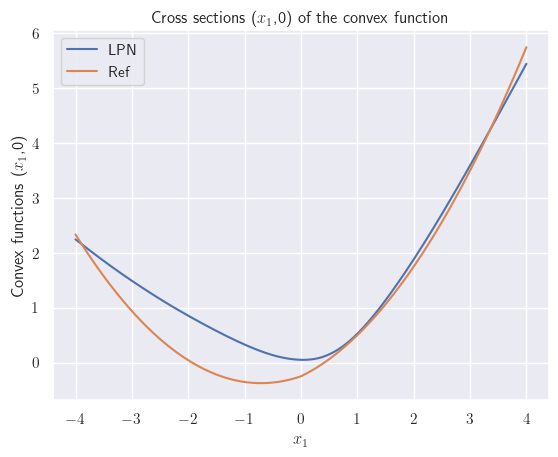

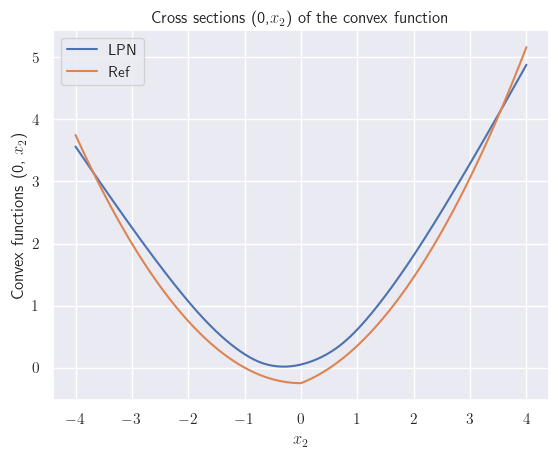

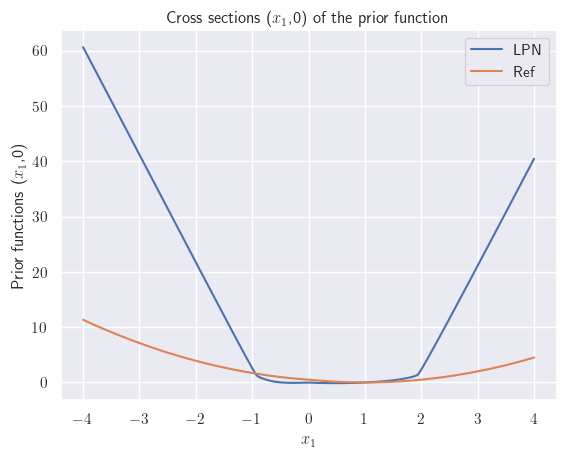

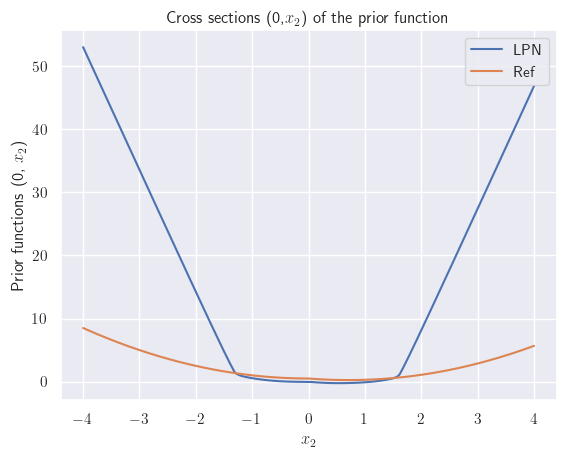

In [11]:
plot_all(lpn_model,a,b,data_points,mu1,mu2,sigma1,sigma2)

gamma = 12.5 -- Train

In [12]:
gamma_loss = 12.5

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(6000):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

iteration 0 loss 0.0010176318464800715
iteration 500 loss 0.0007253640796989202
iteration 1000 loss 0.000523905735462904
iteration 1500 loss 0.00037541688652709126
iteration 2000 loss 0.00026405989774502814
iteration 2500 loss 0.00018294960318598896
iteration 3000 loss 0.00013111114094499499
iteration 3500 loss 9.480833978159353e-05
iteration 4000 loss 7.039308547973633e-05
iteration 4500 loss 5.4513217037310824e-05
iteration 5000 loss 4.3591262510744855e-05
iteration 5500 loss 3.5681128792930394e-05


gamma = 12.5 -- Plot

loss -90.41213989257812
loss -632.9642944335938
loss -1058.08349609375
loss -1439.4854736328125
loss -1792.825439453125
loss -2118.865234375
loss -2396.80712890625
loss -2601.3056640625
loss -2756.72509765625
loss -2886.1728515625
loss -3001.393310546875
loss -3110.9033203125
loss -3219.635498046875
loss -3329.500732421875
loss -3440.7822265625
loss -3553.14111328125
loss -3666.1484375
loss -3779.58203125
loss -3893.408447265625
loss -4007.571044921875
loss -4121.96142578125
loss -4236.462890625
loss -4350.97998046875
loss -4465.45556640625
loss -4579.873046875
loss -4694.23046875
loss -4808.5283203125
loss -4922.7841796875
loss -5036.99755859375
loss -5151.1640625
loss -5265.279296875
loss -5379.34375
loss -5493.35546875
loss -5607.3173828125
loss -5721.23046875
loss -5835.1103515625
loss -5948.95458984375
loss -6062.76318359375
loss -6176.537109375
loss -6290.2802734375
final mse:  0.24210260808467865
max, min: 18.919823 -19.384281
loss -90.41213989257812
loss -660.7507934570312
loss

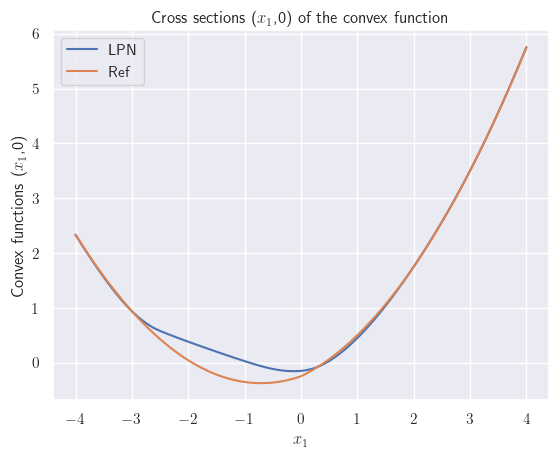

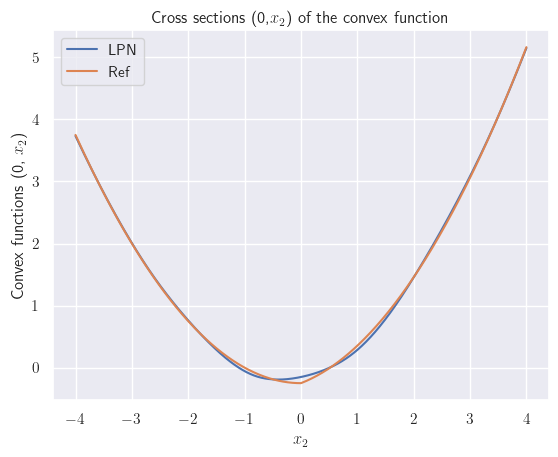

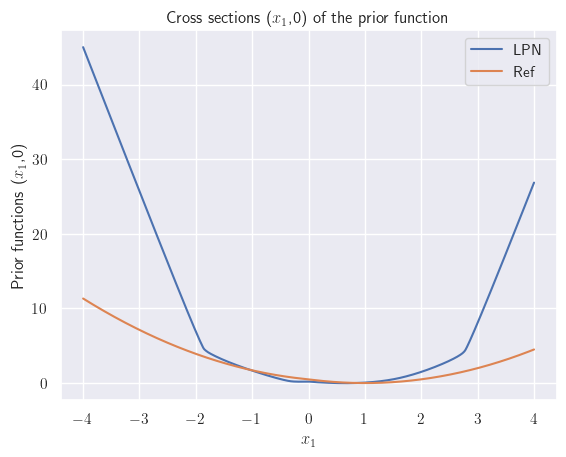

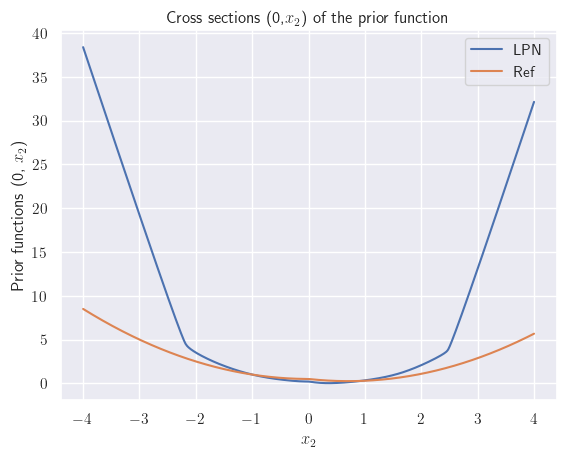

In [13]:
plot_all(lpn_model,a,b,data_points,mu1,mu2,sigma1,sigma2)

gamma = 10 -- Train

In [14]:
gamma_loss = 10

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(10000):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

iteration 0 loss 4.610985342878848e-05
iteration 500 loss 3.534942879923619e-05
iteration 1000 loss 2.83661483990727e-05
iteration 1500 loss 2.337276964681223e-05
iteration 2000 loss 1.9440651158220135e-05
iteration 2500 loss 1.6247928215307184e-05
iteration 3000 loss 1.3824999768985435e-05
iteration 3500 loss 1.2293756299186498e-05
iteration 4000 loss 1.0949075658572838e-05
iteration 4500 loss 9.78678508545272e-06
iteration 5000 loss 8.71777501743054e-06
iteration 5500 loss 7.828176421753597e-06
iteration 6000 loss 7.051229658827651e-06
iteration 6500 loss 6.31302600595518e-06
iteration 7000 loss 5.627870450553019e-06
iteration 7500 loss 5.024075562687358e-06
iteration 8000 loss 4.492700099945068e-06
iteration 8500 loss 4.003643880423624e-06
iteration 9000 loss 3.5509467579686316e-06
iteration 9500 loss 3.14712519866589e-06


gamma = 10 -- Plot

In [15]:
plot_all(lpn_model,a,b,data_points,mu1,mu2,sigma1,sigma2)

loss -129.06236267089844
loss -679.3975219726562
loss -1118.3304443359375
loss -1516.8521728515625
loss -1872.3341064453125
loss -2170.2353515625
loss -2400.609130859375
loss -2590.12744140625
loss -2752.18896484375
loss -2889.697998046875
loss -3006.323974609375
loss -3106.143798828125
loss -3195.057861328125
loss -3278.0029296875
loss -3358.615966796875
loss -3438.91748046875
loss -3519.64013671875
loss -3600.7900390625


KeyboardInterrupt: 